Install in order to use cv2 SIFT

In [ ]:
!pip install imgaug==0.2.5

!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [ ]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [ ]:
pip install --upgrade pip

Imports : 

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage import transform as tf

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac
import matplotlib.pyplot as mpimg
import numpy as np
from skimage import data
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, ORB, plot_matches
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from sklearn.preprocessing import normalize
import matplotlib.image as mpimg
from skimage import measure
from skimage.filters import threshold_li,gaussian,threshold_minimum, threshold_otsu
from skimage.filters import try_all_threshold , threshold_mean , threshold_isodata, threshold_yen , threshold_triangle

from skimage.morphology import remove_small_objects,remove_small_holes,erosion,binary_closing
import scipy.ndimage as sn
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches,BRIEF)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold
import imutils
import tqdm   
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

from scipy.spatial.transform import Rotation as R
from scipy.signal import fftconvolve
from scipy import ndimage

Mount Drive

In [ ]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Mounted at /content/gdrive/


# Part 1 - Registration

Develop 2 registration algorithms first by using FindRetinalFeatures and second by using SegmentBloodVessel.

## EX4 Methods Part 1

In [ ]:
def display_image_points(im, points):
    """
    Dispalay given points on the image with their values and the relevant number.
    :param im: A grayscale image.
    :parma points: An aray shape (N,2), containing N rows of [x,y] coordinates of matched points in image.
    """
    x,y = points[:, 0], points[:, 1]
    fig, ax = plt.subplots()
    ax.plot(x, y, 'bo')

    for i in range(len(x)):
      ax.annotate("Point " + str(i) + " : " +str((int(x[i]),int(y[i]))), xy=(x[i], y[i]), xytext=(-20,20), 
                  textcoords='offset points', ha='center', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                                  color='red'))

    plt.imshow(im)

def display_matches(im1, im2, points1, points2):
    """
    Dispalay matching points.
    :param im1: A grayscale image.
    :param im2: A grayscale image.
    :parma pos1: An aray shape (N,2), containing N rows of [x,y] coordinates of matched points in im1.
    :param pos2: An aray shape (N,2), containing N rows of [x,y] coordinates of matched points in im2.
    """
    im1, im2 = np.array(im1) , np.array(im2)
    # use np.hstack of an image pair im1 and im2, with the matched points provided in pos1 and pos2 overlayed correspondingly as red dots
    horizontally_concatenated_image = np.hstack((im1, im2))
    plt.imshow(horizontally_concatenated_image, cmap='gray')
    # To visualize the detected corner positions, display the image and then plot the points using plt.scatter of plt.plot with ’.’
    plt.scatter(points1[:, 0], points1[:, 1], c='r', marker='.')
    plt.scatter(points2[:, 0] + im1.shape[1], points2[:, 1], c='r', marker='.')
    display_image_points(im1, points1)
    display_image_points(im2, points2)
    plt.show()

Implement the function calcPointBasedReg(BLPoints, FUPoints)

where BL = Baseline points and FU = Follow-up points.
 
The function returns a 3x3 rigidReg rigid 2D transformation matrix of the two translations and rotations of the given points and pairings.
The matrix is such that applying it to FUPoints yields the points that are closest (least squared distance) to the BLPoints.

In [ ]:
def calcPointBasedReg(BLPoints, FUPoints):
    # Compute the weighted centroids of both point sets
    centroid1 = BLPoints.mean(axis=0)
    centroid2 = FUPoints.mean(axis=0)
    # Compute the centered vectors
    centered_points1 = BLPoints - centroid1
    centered_points2 = FUPoints - centroid2
    # Compute the d × d covariance matrix
    covariance = centered_points2.T @ centered_points1
    # Compute the singular value decomposition
    U, sigma , Vt = np.linalg.svd(covariance)

    det = np.linalg.det(U @ Vt)
    m = np.eye(2)
    m[-1,-1] = det
    # m is identity matrix so we could calculate rotation by  U @ Vt 
    rotation = U @ m @ Vt

    translation = centroid2 - (rotation @ centroid1)  
    H = np.eye(3)
    H[:2, :2] = rotation
    H[:2, 2] = translation
    return H

In [ ]:
def remove_caption_bottom(im):
  """This function gets an image and remove the caption where the pixels are mostly black"""
  max = 0
  ind = 0 
  h,w,d= im.shape
  total = h*w*d
  for i in range(h):
    count = total - np.count_nonzero(im[i,:])
    if(count > max):
      max = count
      ind = i
  cropped= im[:ind,:]
  return cropped

## FindRetinalFeatures

FindRetinaFeatures(Image) - The function will find strong features in the image to use for registration. You can use
algorithms like SURF, SIFT and ORB.

In [ ]:
def FindRetinaFeatures(bl,fu,ratio):
  """This function detect features using SIFT , it matches features using Brute-force,
  and picks matched points using KNN.
  It gets as input a baseline image, a follow-up image and a ratio to be used by KNN.
  Choosing inliers is done according to the ratio.
  The function returns a list of good matches"""
  # Initiate SIFT detector
  sift = cv2.xfeatures2d.SIFT_create()
  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(bl,None)
  kp2, des2 = sift.detectAndCompute(fu,None)
  # BFMatcher with default params
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des1,des2, k=2)
  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < ratio*n.distance:
          good.append([m])
  return kp1,kp2,good

In [ ]:
def getPoints(bl,fu,ratio):
  """This function finds important points on the image to be used in order to find 
  the correct homography.
  It gets as input a baseline image, a follow-up image and a ratio to be used by KNN.
  It returns baseline image points and follow-up image points"""
  kp1,kp2,good = FindRetinaFeatures(bl,fu,ratio)
  BLPoints = np.zeros((len(good), 2), dtype=np.float32)
  FUPoints = np.zeros((len(good), 2), dtype=np.float32)
  for i in range(len(good)):
      BLPoints[i, :] = kp1[good[i][0].queryIdx].pt
      FUPoints[i, :] = kp2[good[i][0].trainIdx].pt
  return BLPoints,FUPoints

In [ ]:
def Registration(bl,fu,BLPoints,FUPoints):
  """This function preforms a registratation on follow-up image.
  It gets as input a baseline image, a follow-up image ,baseline image points and follow-up image points.
  It calculates the homography, and wrap fu.
  It shows both images - wraped fu on top of bl, and return wraped fu.
  """  
  rigidReg = calcPointBasedReg(BLPoints,FUPoints)
  # register the FU to the BL
  img_warped = warp(fu, rigidReg)
  img_warped_gray = rgb2gray(img_warped)
  plt.imshow(bl, cmap='gray') 
  plt.imshow(img_warped_gray, cmap='jet', alpha=0.7)
  plt.show()
  return img_warped

## Example

### BL1 FU1 Example

Read images and remove caption

In [ ]:
bl1_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL01.tif'
fu1_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU01.tif'
bl1 = Image.open(bl1_path)
fu1 = Image.open(fu1_path)
bl1_arr = np.array(bl1)
fu1_arr = np.array(fu1)
bl1 = remove_caption_bottom(bl1_arr)
fu1 = remove_caption_bottom(fu1_arr)

Get important points

In [ ]:
BLPoints1,FUPoints1 = getPoints(bl1,fu1,0.56)

Print points from both images

In [ ]:
BLPoints1,FUPoints1 = BLPoints1[1:],FUPoints1[1:]
BLPoints1,FUPoints1

(array([[ 361.0509  ,   79.12682 ],
        [ 571.1055  , 1350.6099  ],
        [ 957.2317  ,   20.255173]], dtype=float32),
 array([[ 588.9942  ,   83.300354],
        [ 738.9477  , 1375.9009  ],
        [1189.9664  ,   55.421146]], dtype=float32))

Display points from both images

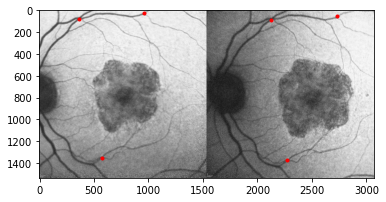

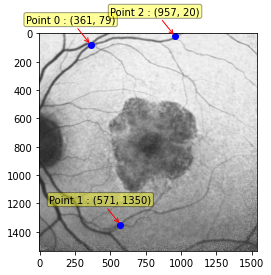

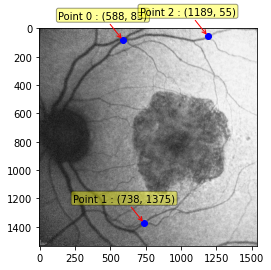

In [ ]:
display_matches(bl1, fu1, BLPoints1, FUPoints1)

Display  Registration

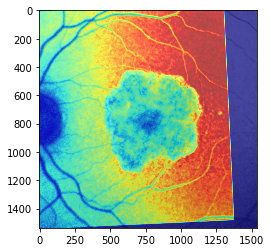

In [ ]:
fu1_reg = Registration(bl1,fu1,BLPoints1,FUPoints1)

### BL3 FU3 Example

In [ ]:
bl3_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL03.bmp'
fu3_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU03.bmp'
bl3 = Image.open(bl3_path)
fu3 = Image.open(fu3_path)
bl3_arr = np.array(bl3)
fu3_arr = np.array(fu3)
bl3 = remove_caption_bottom(bl3_arr)
fu3 = remove_caption_bottom(fu3_arr)

In [ ]:
BLPoints3,FUPoints3 = getPoints(bl3,fu3,0.3)

In [ ]:
BLPoints3,FUPoints3

(array([[ 593.0234 ,  818.9755 ],
        [ 954.75586, 1259.416  ],
        [1033.3381 ,  581.9804 ],
        [1036.6514 ,  544.4159 ]], dtype=float32),
 array([[ 875.7165,  805.6648],
        [1235.4127, 1257.8584],
        [1322.1562,  567.1864],
        [1328.2178,  531.7546]], dtype=float32))

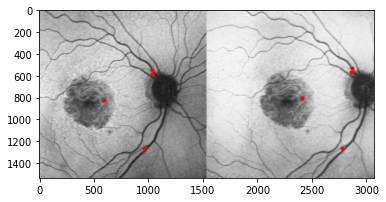

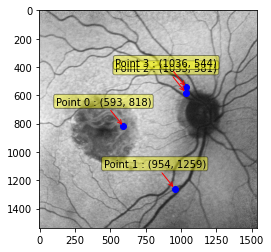

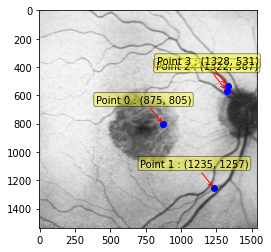

In [ ]:
display_matches(bl3, fu3, BLPoints3, FUPoints3)

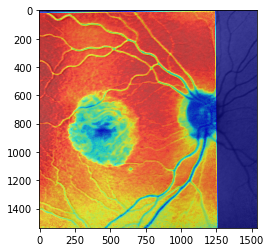

In [ ]:
Registration(bl3,fu3,BLPoints3,FUPoints3)

### BL4 FU4 Example

In [ ]:
bl4_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL04.bmp'
fu4_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU04.bmp'
bl4 = Image.open(bl4_path)
fu4 = Image.open(fu4_path)
bl4_arr = np.array(bl4)
fu4_arr = np.array(fu4)
bl4 = remove_caption_bottom(bl4_arr)
fu4 = remove_caption_bottom(fu4_arr)

In [ ]:
BLPoints4,FUPoints4 = getPoints(bl4,fu4,0.288)

In [ ]:
BLPoints4,FUPoints4

(array([[181.81955, 335.0661 ],
        [344.5027 , 176.87854],
        [771.8338 , 540.46533]], dtype=float32), array([[317.38718, 565.9777 ],
        [488.00885, 418.08792],
        [892.3113 , 817.027  ]], dtype=float32))

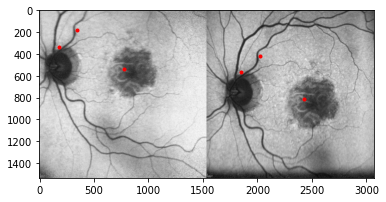

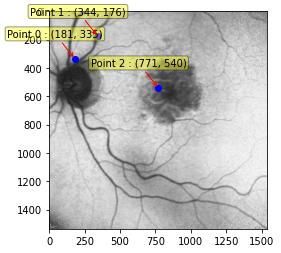

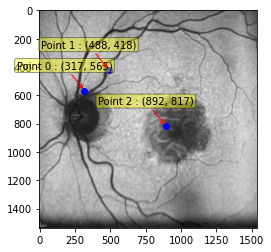

In [ ]:
display_matches(bl4, fu4, BLPoints4, FUPoints4)

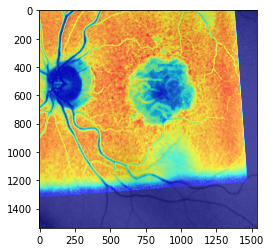

In [ ]:
Registration(bl4,fu4,BLPoints4,FUPoints4)

### BL5 FU5 Example

In [ ]:
bl5_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL05.bmp'
fu5_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU05.bmp'
bl5 = Image.open(bl5_path)
fu5 = Image.open(fu5_path)
bl5_arr = np.array(bl5)
fu5_arr = np.array(fu5)
bl5 = remove_caption_bottom(bl5_arr)
fu5 = remove_caption_bottom(fu5_arr)

In [ ]:
BLPoints5,FUPoints5 = getPoints(bl5,fu5,0.45)

In [ ]:
BLPoints5,FUPoints5

(array([[ 752.04205,  346.8456 ],
        [1259.4248 ,  178.78279],
        [1350.0834 ,  175.55168]], dtype=float32),
 array([[ 749.7872 ,  333.6271 ],
        [1240.7383 ,  195.09813],
        [1326.7828 ,  193.65015]], dtype=float32))

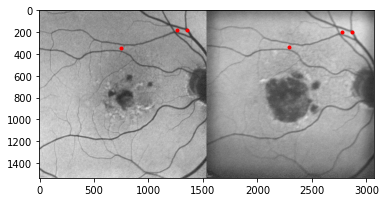

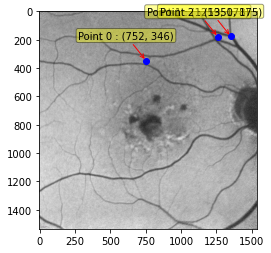

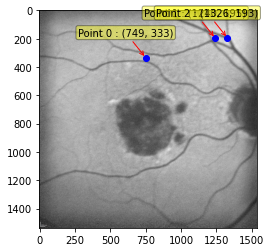

In [ ]:
display_matches(bl5, fu5, BLPoints5, FUPoints5)

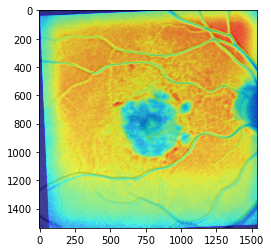

In [ ]:
Registration(bl5,fu5,BLPoints5,FUPoints5)

## SegmentBloodVessel

In [ ]:
def find_translation(image,offset_image):
  """This function gets as input the follow-up image and the rotation of the follow-up image,
  It calculates the translation matrix, and the upsampled DFT.
  It also shows the images it got, and a supersampled XC sub-area.
  It prints detected subpixel offset and returns the translation matrix """
  shift, error, diffphase = register_translation(image, offset_image, 100)

  fig = plt.figure(figsize=(8, 3))
  ax1 = plt.subplot(1, 3, 1, adjustable='box')
  ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box')
  ax3 = plt.subplot(1, 3, 3)

  ax1.imshow(image, cmap='gray')
  ax1.set_axis_off()
  ax1.set_title('Reference image')

  ax2.imshow(offset_image.real, cmap='gray')
  ax2.set_axis_off()
  ax2.set_title('Offset image')

  # Calculate the upsampled DFT
  image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
  cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
  ax3.imshow(cc_image.real)
  ax3.set_axis_off()
  ax3.set_title("Supersampled XC sub-area")

  plt.show()

  print("Detected subpixel offset (y, x): {}".format(shift))
  return shift

In [ ]:
def show_Registration(bl,best_rotated_fu,translation):
  """This function gets as input a baseline image, rotated follow-up image and a translation matrix.
  It calculates the affine transform of the rotated fu with the transaltion and shows
  it above bl. """
  fu_final = ndimage.affine_transform(best_rotated_fu, [[1,0],[0,1]], [translation[0] * -1, translation[1] * -1])
  plt.imshow(bl, cmap='gray') 
  plt.imshow(fu_final, cmap='jet', alpha=0.7)
  plt.show()
  return fu_final

In [ ]:
def Segmenatation_Registration(bl,fu):
  """This function preforms registration using BloodVesselSegmentation function.
  It gets as input a baseline image and a follow-up image.
  It create bl segmentation and fu segmentation, rotates the fu segmentations, 
  perform cross-correlation between the two segmentations. Than it finds the global max cross-correlation.
  The global maximum score of the cross- correlation will be the rotation variable.
  Later, it rotates the fu according to the rotation variable, and it finds the
  translation. """
  bl_seg = SegmentBloodVessel(bl,False)
  fu_seg = SegmentBloodVessel(fu,False)
  bl_seg = bl_seg.astype(np.float32)
  fu_seg = fu_seg.astype(np.float32)
  max = -1
  rotation_var = 0
  for angle in range(0, 360, 1):
    r = R.from_euler('z', angle, degrees=True)
    rotation_matrix = r.as_matrix()
    rotated_fu = ndimage.affine_transform(fu_seg, rotation_matrix[:2,:2], (0, 0))
    correlation = np.sum(fftconvolve(bl_seg, rotated_fu[::-1,::-1], mode='same'))
    # correlation= np.corrcoef(bl_seg.reshape(-1), rotated_fu.reshape(-1))[0][1]
    if correlation > max:
      max = correlation
      rotation_var = angle

  print("Chosen angle is ",rotation_var)
  
  best_rotated_fu_seg = imutils.rotate(fu_seg, rotation_var)
  translation = find_translation(bl_seg,best_rotated_fu_seg)
  best_rotated_fu = imutils.rotate(fu, rotation_var)
  # Wrap the two segmentation
  show_Registration(bl_seg,best_rotated_fu_seg,translation)
  register the FU to the BL
  fu_final = show_Registration(bl,best_rotated_fu,translation)
  return fu_final , translation , rotation_var


## EX4 Methods Part 2

SegmentBloodVessel(Image) – perform segmentation of the blood vessels in the retina. You may assume the atrophy
in the center (this is the AMD atrophy, marked by the X in the image below) is not part of the segmentation, and the
caption at the bottom can be removed. 

In [ ]:
def SegmentBloodVessel(image,is_first):
  no_caption = remove_caption_bottom(image)
  blurred_image = gaussian(no_caption,5)
  blurred_image = blurred_image.astype('uint8')
  binary_local = cv2.adaptiveThreshold(blurred_image, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 2)
  new_im = binary_closing(binary_local)
  no_atrophy = remove_atrophy_from_seg(image,is_first)
  my_im = np.copy(new_im)
  res = np.multiply(no_atrophy,my_im)
  plt.imshow(res,cmap = 'gray')
  return res

def remove_caption_bottom(im):
  """This function gets an image and remove the caption where the pixels are mosly black"""
  max = 0
  ind = 0 
  h,w= im.shape
  total = h*w
  for i in range(h):
    count = total - np.count_nonzero(im[i,:])
    if(count > max):
      max = count
      ind = i
  cropped= im[:ind,:]
  return cropped

def remove_atrophy_from_seg(im,is_first):
  """This function gets an image after removing caption, and a flag whether to find 
  the first maximal object or the second, and returns pixels to remove that belongs to the
  atrophy."""
  # crop image to remove caption
  cropped = remove_caption_bottom(im)
  # blur
  filtered_img = gaussian(cropped, sigma=1)
  # find threshold
  thresh = threshold_li(cropped)
  print("Find Threshold using Li - ",thresh)
  # fix threshold to better identify atrophy
  binary = cropped > thresh- 25 
  # flip for post processing
  flip_binary = np.where(binary,0,1)
  # remove small objects
  new_image = post_processing(flip_binary)
  if not is_first:
    new_image = gaussian(new_image,1)
  # erision operation to fill the area outside the atrophy with black
  erosion_image = erosion(new_image)
  erosion_image = erosion(erosion_image)
  erosion_image = erosion(erosion_image)
  erosion_image = erosion(erosion_image)
  erosion_image = erosion(erosion_image)
  # Find the first/second maximal object of the image (the atrophy)
  astrophy, n_labels = sn.label(erosion_image)
  if is_first:
      obj = sn.sum(erosion_image, astrophy, range(n_labels + 1))
      max_obj = np.partition(obj, -1, 0)[-1]
  else:
      obj = sn.sum(erosion_image, astrophy, range(n_labels + 2))
      max_obj = np.partition(obj, -2, 0)[-2]
  cond = (obj != max_obj)
  pixels_to_remove = cond[astrophy]
  return pixels_to_remove

In [ ]:
def read_image(file_name, representation):
    """reads an image file and converts it into a given representation.
        defning whether the output should be a grayscale image (1) or an RGB image (2).
    """
    img = mpimg.imread(file_name).astype(np.float64)
    if representation == GRAY:
        return rgb2gray(img)
    elif representation == RGB:
        return img 
    else:
        print("ERROR")

def post_processing(new_im):
  """This function gets an iamge as input and finds min_size in order to be left
  with single connectivity component. It performes morphological operations and
  return an image with one connectivity component"""
  h,w= new_im.shape
  num_of_pixels = h*w
  num_of_non_zero = np.count_nonzero(new_im)
  num_of_black_pixels = num_of_pixels - num_of_non_zero
  min_size = num_of_black_pixels//(2*w)
  print("min size is ",min_size)
  print("Before morphologic operations  ",measure.label(new_im, return_num=True)[1])
  new_im = new_im.astype(bool)
  data = remove_small_holes(new_im, min_size, connectivity=1)
  print("after remove_small_holes ",measure.label(data, return_num=True)[1])
  data = remove_small_objects(new_im, min_size=min_size, connectivity=1)
  print("after remove_small_objects ",measure.label(data, return_num=True)[1])
  # plt.imshow(data,cmap='gray')
  return data

## Examples 

### Read Example

In [ ]:
RGB = 2
GRAY = 1

In [ ]:
bl2_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL03.bmp'
fu2_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU03.bmp'
bl2 = read_image(bl2_path, GRAY)
fu2 = read_image(fu2_path, GRAY)

bl3_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL03.bmp'
fu3_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU03.bmp'
bl3 = read_image(bl3_path, GRAY)
fu3 = read_image(fu3_path, GRAY)

bl4_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL04.bmp'
fu4_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU04.bmp'
bl4 = read_image(bl4_path, GRAY)
fu4 = read_image(fu4_path, GRAY)

bl5_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL05.bmp'
fu5_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU05.bmp'
bl5 = read_image(bl5_path, GRAY)
fu5 = read_image(fu5_path, GRAY)

### Final Results

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10
Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7
Chosen angle is  0


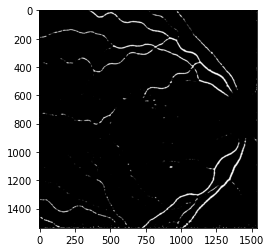

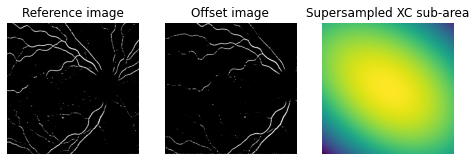

Detected subpixel offset (y, x): [  16.88 -289.7 ]


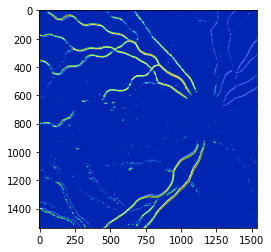

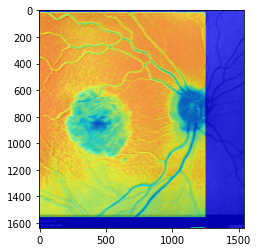

In [ ]:
fu2_reg_final = Segmenatation_Registration(bl2,fu2)

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10
Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7
Chosen angle is  0


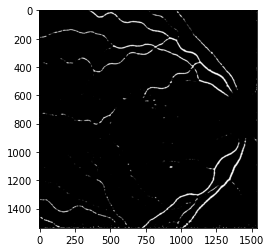

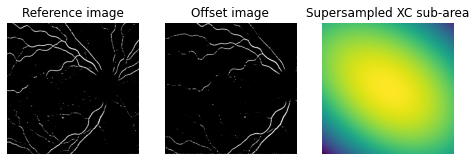

Detected subpixel offset (y, x): [  16.88 -289.7 ]


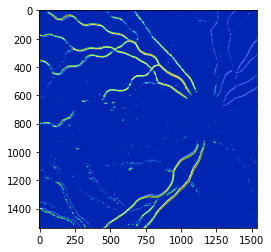

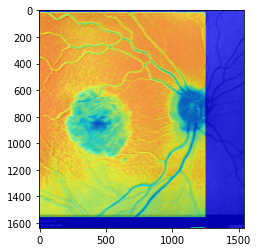

In [ ]:
fu3_reg_final = Segmenatation_Registration(bl3,fu3)

Best results I got by using fft to calculate correlation between bl and rotated fu, were on cases bl2-fu2, and bl3-fu3 .
Case 5 also had fine results using corrcoef to calculate correlation.
Incorrect rotation angle was the cause of bad results. To overcome this I tried different segmentation by changing the parameters of gaussian blur and adaptiveThreshold in the function SegmentBloodVessels. I also tried diffetent ways to calculate correlation - fft and corrcoef.
You can see the examples below to get some idea about the proccess.

### BL2,FU2 Example - **fft**

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10
Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7
Chosen angle is  359


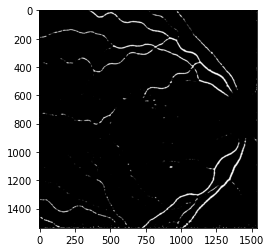

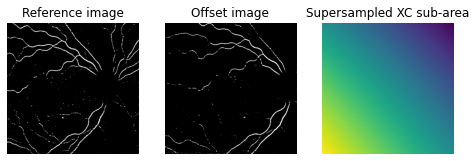

Detected subpixel offset (y, x): [  18.89 -292.19]


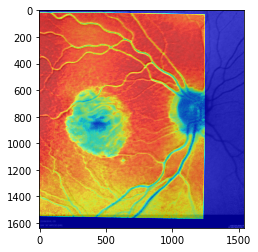

In [ ]:
fu2_final = Segmenatation_Registration(bl2,fu2)

### BL2, FU2 - **corrcoef**

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10
Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7
Chosen angle is  13


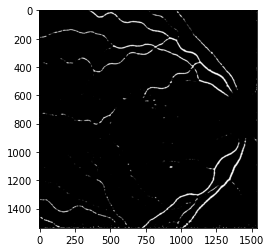

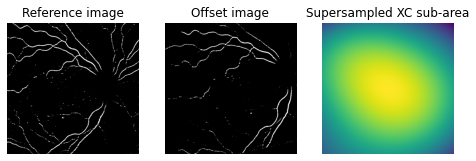

Detected subpixel offset (y, x): [  60.52 -328.41]


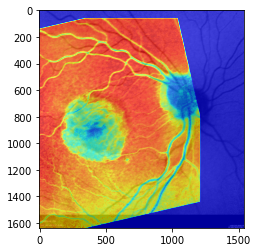

In [ ]:
fu2_registration = Segmenatation_Registration(bl2,fu2)

### BL3, FU3 - **corrcoef**

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10
Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7
Chosen angle is  13


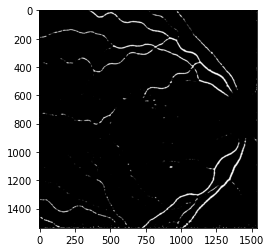

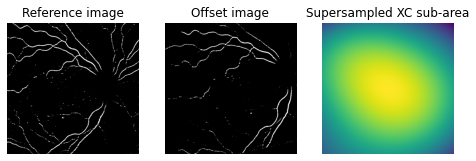

Detected subpixel offset (y, x): [  60.52 -328.41]


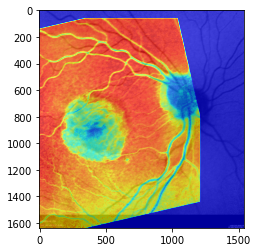

In [ ]:
fu3_registration = Segmenatation_Registration(bl3,fu3)

### BL5, FU5 - corrcoef

Find Threshold using Li -  149.11268460939542
min size is  673
Before morphologic operations   24876
after remove_small_holes  24819
after remove_small_objects  12
Find Threshold using Li -  133.28869996500467
min size is  637
Before morphologic operations   11313
after remove_small_holes  11140
after remove_small_objects  10
Chosen angle is  1


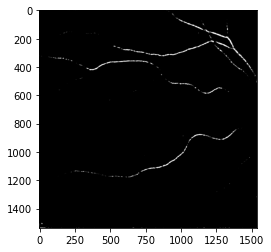

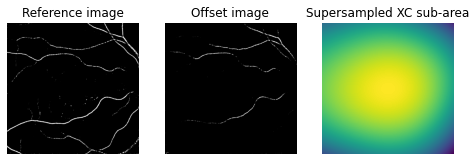

Detected subpixel offset (y, x): [-7.76 33.58]


(array([[  0.        ,   0.        ,   0.        , ...,  80.80962039,
          73.08258833,  79.05440467],
        [  0.        ,   0.        ,   0.        , ...,  99.20008348,
          85.4976668 , 105.6559056 ],
        [  0.        ,   0.        ,   0.        , ...,  99.91216929,
          99.51952953,  89.65909729],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]), array([-7.76, 33.58]), 1)

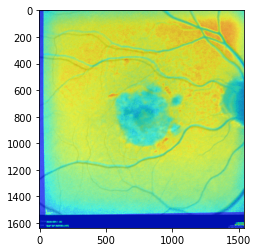

In [ ]:
fu5_reg = Segmenatation_Registration(bl5,fu5)

Compare to registration by features

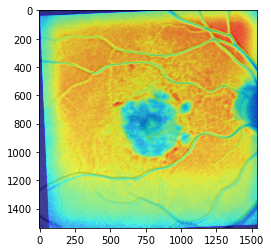

In [ ]:
Registration(bl5,fu5,BLPoints5,FUPoints5)

### Process

#### BL2 FU2 Example - flow of work - (blood vessel segmentation with different parameteres )

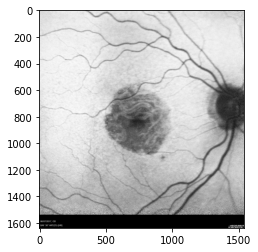

In [ ]:
plt.imshow(fu2,cmap = 'gray')

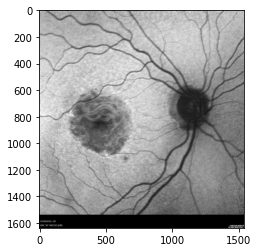

In [ ]:
plt.imshow(bl2,cmap = 'gray')

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10


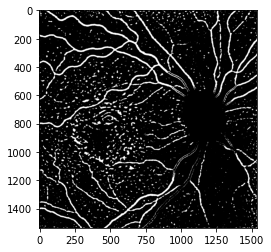

In [ ]:
bl2_seg = SegmentBloodVessel(bl2,True)

Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7


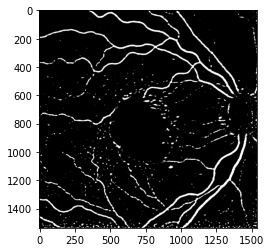

In [ ]:
fu2_seg = SegmentBloodVessel(fu2,False)

In [ ]:
rotation_var = find_rotation_angle(bl2_seg,fu2_seg)

100%|██████████| 359/359 [01:45<00:00,  3.42it/s]


In [ ]:
rotation_var

354

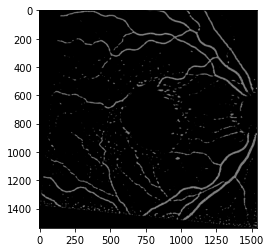

In [ ]:
rotation_mat = cv2.getRotationMatrix2D((fu2_seg.shape[1], fu2_seg.shape[0]), rotation_var, 1)
translation = [0,0]
fu_seg_rotated = affine_transform(fu2_seg, rotation_mat,translation )
plt.imshow(fu_seg_rotated,cmap = 'gray')

In [ ]:
rotation_mat

array([[ 9.94521895e-01, -1.04528463e-01,  1.68970088e+02],
       [ 1.04528463e-01,  9.94521895e-01, -1.52141351e+02]])

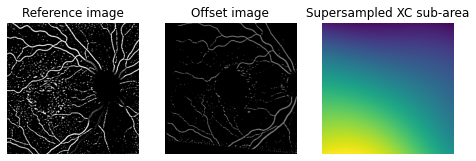

Detected subpixel offset (y, x): [ 112.36 -348.19]


In [ ]:
shift = find_translation(bl2_seg,fu_seg_rotated)

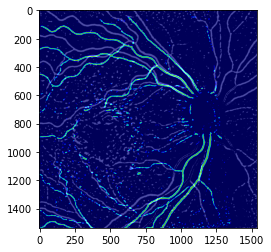

In [ ]:
    # Wrap the two segmentation
    fu_seg_final = ndimage.affine_transform(fu2_seg, rotation, [shift[0] * -1, shift[1] * -1])
    plt.imshow(bl2_seg, cmap='gray') 
    plt.imshow(fu_seg_final, cmap='jet', alpha=0.7)


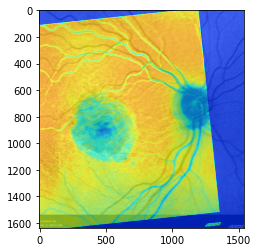

In [ ]:
    fu_img_final = ndimage.affine_transform(fu2, rotation, [shift[0] * -1, shift[1] * -1])
    plt.imshow(bl2, cmap='gray') 
    plt.imshow(fu_img_final, cmap='jet', alpha=0.7)

#### BL3 FU3 Example - flow of work 


Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10


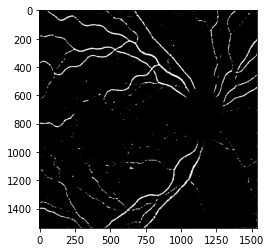

In [ ]:
bl3_seg = SegmentBloodVessel(bl3,False)

Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7


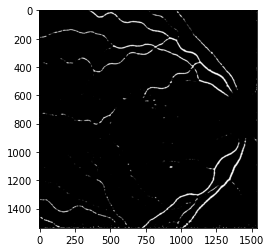

In [ ]:
fu3_seg = SegmentBloodVessel(fu3,False)

In [ ]:
bl3_seg = bl3_seg.astype(np.float32)
fu3_seg = fu3_seg.astype(np.float32)

In [ ]:
res = fftconvolve(bl3_seg, fu3_seg[::-1,::-1], mode='same')
np.sum(res) 

1669632.6666666667

In [ ]:
from scipy import signal
cor = signal.correlate2d (bl3_seg, fu3_seg)
np.sum(cor)

In [ ]:
    
    max = -1
    rotation_var = 0
    FU_rotate = None
    for theta in tqdm.tqdm(np.arange(1, 360, 1)):
        r = R.from_euler('z', theta, degrees=True)
        rotation_matrix = r.as_matrix()
        # print(rotation_matrix)
        FU_rot = ndimage.affine_transform(fu3_seg, rotation_matrix[:2,:2], (0, 0))
        # correlation = cv2.matchTemplate(bl3_seg, FU_rot, cv2.TM_CCORR)
        correlation = np.sum(fftconvolve(bl3_seg, FU_rot[::-1,::-1], mode='same'))
        if correlation > max:
            max = correlation
            rotation_var = theta
            FU_rotate = FU_rot

In [ ]:
rotation_var

359

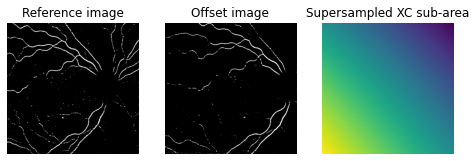

Detected subpixel offset (y, x): [  18.89 -292.19]


In [ ]:
FU_final_rotate = imutils.rotate(fu3_seg, rotation_var)
translation = find_translation(bl3_seg,FU_final_rotate)

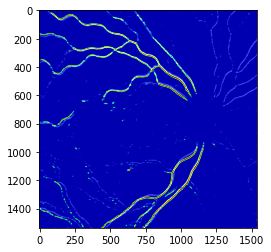

In [ ]:
    # Wrap the two segmentation
    fu_seg_final = ndimage.affine_transform(FU_final_rotate, [[1,0],[0,1]], [translation[0] * -1, translation[1] * -1])
    plt.imshow(bl3_seg, cmap='gray') 
    plt.imshow(fu_seg_final, cmap='jet', alpha=0.7)

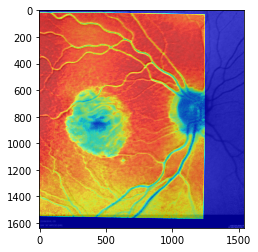

In [ ]:
    FU_final_rotate = imutils.rotate(fu3, ang)
    # Wrap the two segmentation
    fu_final = ndimage.affine_transform(FU_final_rotate, [[1,0],[0,1]], [translation[0] * -1, translation[1] * -1])
    plt.imshow(bl3, cmap='gray') 
    plt.imshow(fu_final, cmap='jet', alpha=0.7)

Compare to registration by features

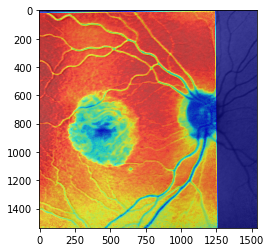

In [ ]:
Registration(bl3,fu3,BLPoints3,FUPoints3)

#### BL3,FU3 (blood vessel segmentation with different parameteres )

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10
Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7


100%|██████████| 359/359 [01:16<00:00,  4.68it/s]


Rotation angel is  1


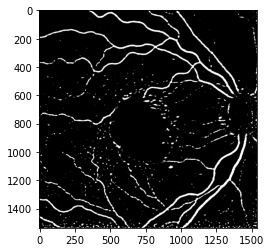

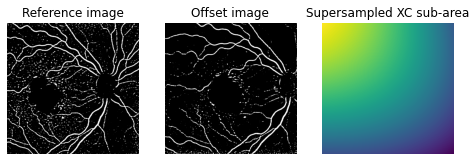

Detected subpixel offset (y, x): [  15.31 -290.26]


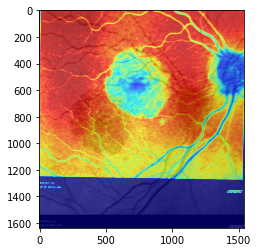

In [ ]:
segmentation_registration(bl3,fu3,False,False)

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10
Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7


100%|██████████| 359/359 [01:21<00:00,  4.41it/s]


Rotation angel is  1


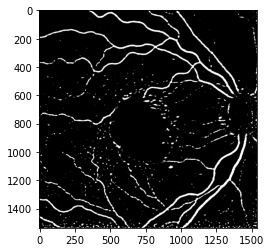

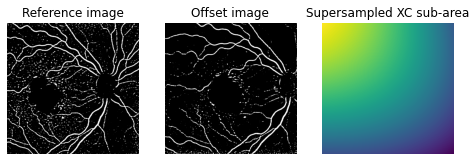

Detected subpixel offset (y, x): [  15.31 -290.26]


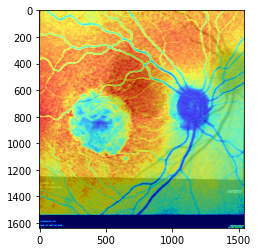

In [ ]:
segmentation_registration(bl3,fu3,False,False)

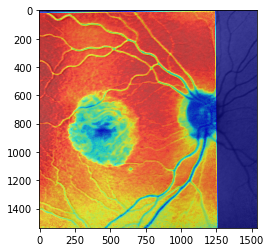

In [ ]:
Registration(bl3,fu3,BLPoints3,FUPoints3)

#### BL4 FU4 Example - flow of work with corrcoef


Find Threshold using Li -  143.14638006258141
min size is  684
Before morphologic operations   12753
after remove_small_holes  12685
after remove_small_objects  8


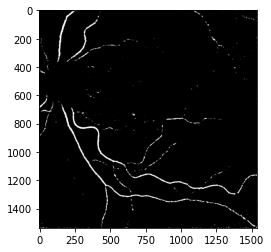

In [ ]:
bl4_seg = SegmentBloodVessel(bl4,False)

Find Threshold using Li -  116.25254984547628
min size is  664
Before morphologic operations   3374
after remove_small_holes  3342
after remove_small_objects  10


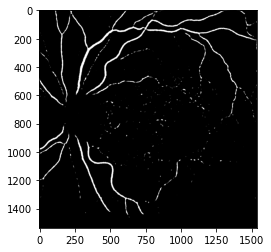

In [ ]:
fu4_seg = SegmentBloodVessel(fu4,False)

In [ ]:
bl4_seg = bl4_seg.astype(np.float32)
fu4_seg = fu4_seg.astype(np.float32)

In [ ]:
cor = np.corrcoef(bl4_seg.reshape(-1), fu4_seg.reshape(-1))[0][1]
cor

0.01654744741474601

In [ ]:
    max = -1
    rotation_var = 0
    for ang in tqdm.tqdm(np.arange(0, 360, 1)):
        r = R.from_euler('z', ang, degrees=True)
        rotation_matrix = r.as_matrix()
        FU_rot = ndimage.affine_transform(fu4_seg, rotation_matrix[:2,:2], (0, 0))
        correlation = np.corrcoef(bl4_seg.reshape(-1), FU_rot.reshape(-1))[0][1]
        if correlation > max:
            max = correlation
            rotation_var = ang

 25%|██▌       | 91/360 [00:23<00:43,  6.24it/s]/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 360/360 [01:17<00:00,  4.63it/s]


In [ ]:
rotation_var

69

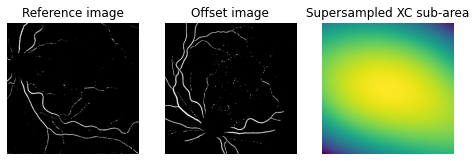

Detected subpixel offset (y, x): [84.05 -9.28]


In [ ]:
FU_final_rotate = imutils.rotate(fu4_seg.astype(np.float32), rotation_var)
translation = find_translation(bl4_seg,FU_final_rotate)

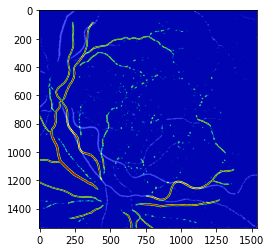

In [ ]:
    # Wrap the two segmentation
    fu_seg_final = ndimage.affine_transform(FU_final_rotate, [[1,0],[0,1]], [translation[0] * -1, translation[1] * -1])
    plt.imshow(bl4_seg, cmap='gray') 
    plt.imshow(fu_seg_final, cmap='jet', alpha=0.7)

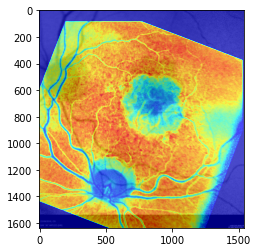

In [ ]:
    FU_final_rotate = imutils.rotate(fu4, rotation_var)
    # Wrap the two segmentation
    fu_final = ndimage.affine_transform(FU_final_rotate, [[1,0],[0,1]], [translation[0] * -1, translation[1] * -1])
    plt.imshow(bl4, cmap='gray') 
    plt.imshow(fu_final, cmap='jet', alpha=0.7)

#### BL5 FU5 Example - flow of work with corrcoef


Find Threshold using Li -  149.11268460939542
min size is  673
Before morphologic operations   24876
after remove_small_holes  24819
after remove_small_objects  12


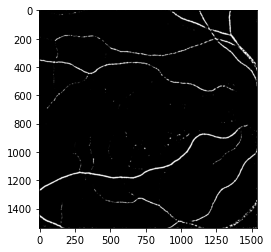

In [ ]:
bl5_seg = SegmentBloodVessel(bl5,False)

Find Threshold using Li -  133.28869996500467
min size is  637
Before morphologic operations   11313
after remove_small_holes  11140
after remove_small_objects  10


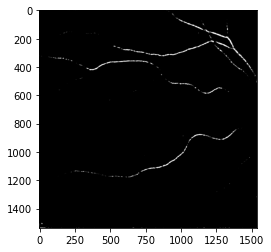

In [ ]:
fu5_seg = SegmentBloodVessel(fu5,False)

In [ ]:
bl5_seg = bl5_seg.astype(np.float32)
fu5_seg = fu5_seg.astype(np.float32)

In [ ]:
    max = -1
    rotation_var = 0
    for ang in tqdm.tqdm(np.arange(0, 360, 1)):
        r = R.from_euler('z', ang, degrees=True)
        rotation_matrix = r.as_matrix()
        FU_rot = ndimage.affine_transform(fu5_seg, rotation_matrix[:2,:2], (0, 0))
        correlation = np.corrcoef(bl5_seg.reshape(-1), FU_rot.reshape(-1))[0][1]
        if correlation > max:
            max = correlation
            rotation_var = ang

100%|██████████| 360/360 [01:20<00:00,  4.48it/s]


In [ ]:
rotation_var

1

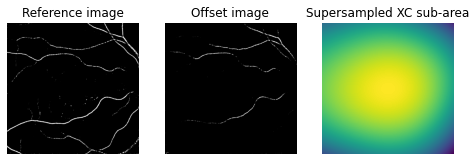

Detected subpixel offset (y, x): [-7.76 33.58]


In [ ]:
FU_final_rotate = imutils.rotate(fu5_seg.astype(np.float32), rotation_var)
translation = find_translation(bl5_seg,FU_final_rotate)

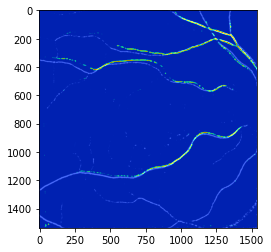

In [ ]:
    # Wrap the two segmentation
    fu_seg_final = ndimage.affine_transform(FU_final_rotate, [[1,0],[0,1]], [translation[0] * -1, translation[1] * -1])
    plt.imshow(bl5_seg, cmap='gray') 
    plt.imshow(fu_seg_final, cmap='jet', alpha=0.7)

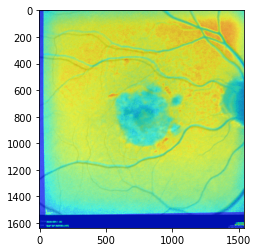

In [ ]:
    FU_final_rotate = imutils.rotate(fu5, rotation_var)
    # Wrap the two segmentation
    fu_final = ndimage.affine_transform(FU_final_rotate, [[1,0],[0,1]], [translation[0] * -1, translation[1] * -1])
    plt.imshow(bl5, cmap='gray') 
    plt.imshow(fu_final, cmap='jet', alpha=0.7)

# Part 2 - Detect the changes

In [ ]:
def detect_changes(bl_path,fu_path,ration):
  """This function detects changes on both baseline image and folow-up image.
  It gets bl image path, fu image path and a ration for finding inliers.
  It read the images, remove the caption, gets the points to calculate homography, and
  preforn registration.
  Next the algorithm works as followed: 
    1. Normalize both images by columns.
    2. Subtract FU from BL after registration
    3. Remove all pixels that are above 0 and take the absolute value of the results
    4. Use some threshold method to remove some of the noise, without removing the lesion region.
    5. Use skimage.segmentation.clear_border to clean noise touching the boundary.
    6. Remove small objects.
    7. Remove Blood Vessels.
    8. Morphologically close
    9. Draw the borders.
  """
  # read images
  bl = Image.open(bl_path)
  fu = Image.open(fu_path)
  bl_arr = np.array(bl)
  fu_arr = np.array(fu)
  # remove caption
  bl = remove_caption_bottom(bl_arr)
  fu = remove_caption_bottom(fu_arr)
  # find points
  BLPoints,FUPoints = getPoints(bl,fu,ration)
  BLPoints,FUPoints = BLPoints[1:],FUPoints[1:]
  # registration
  fu_registration = Registration(bl,fu,BLPoints,FUPoints)
  # create gray images
  bl_gray = rgb2gray(bl)
  fu_registration_gray = rgb2gray(fu_registration)
  # normalize
  normalized_bl = normalize(bl_gray, axis=0, norm="max")
  normalized_fu = normalize(fu_registration_gray, axis=0, norm="max")
  # substract
  sub = normalized_bl - normalized_fu
  plt.title("Normalize both images, and subtract FU from BL after registration")
  plt.imshow(sub,cmap='gray')
  plt.show()
  # remove values above 0 
  remove_vals_above_zero = np.abs(np.where(sub<0,0,sub))
  plt.title("Remove all pixels that are above 0 and take the absolute value of the results")
  plt.imshow(remove_vals_above_zero,cmap='gray')
  plt.show()
  # threshold
  # thresh = threshold_yen(remove_vals_above_zero)
  thresh = threshold_otsu(remove_vals_above_zero)
  print("Threshold is - ",thresh)
  binary = remove_vals_above_zero > thresh 
  plt.title("Use otsu threshold method to remove some of the noise")
  # plt.title("Use Yen threshold method to remove some of the noise")
  plt.imshow(binary,cmap='gray')
  plt.show()
  # clean noise
  clear_border_img = clear_border(binary)
  plt.title("Clean noise touching the boundary")
  plt.imshow(clear_border_img,cmap='gray')
  plt.show()
  # remove small objects
  remove_small_obj = remove_small_objects(clear_border_img,700)
  plt.title("Remove Small Objects")
  plt.imshow(remove_small_obj,cmap='gray')
  plt.show()
  # morphologically close
  closing = binary_closing(remove_small_obj)
  plt.title("Morphologically close")
  plt.imshow(closing,cmap='gray')
  plt.show()
  # Draw Border
  contours_bl = cv2.findContours(closing.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(bl, contours_bl[1], -1, (255, 0, 0), 3)
  plt.title("Baseline Changes")
  plt.imshow(bl, cmap='gray')
  plt.show()
  contours_fu = cv2.findContours(closing.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(fu_registration, contours_fu[1], -1, (255, 0, 0), 3)
  plt.title("Follow-up Changes")
  plt.imshow(fu_registration, cmap='gray')
  plt.show()


## Example using Features Registration 

### BL1,FU1 - Yen thresholding



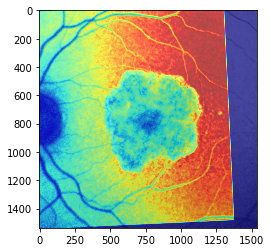

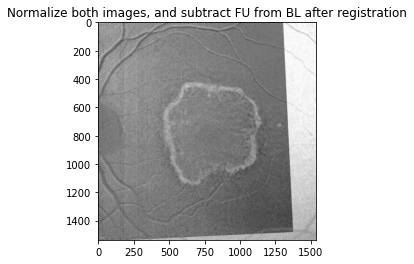

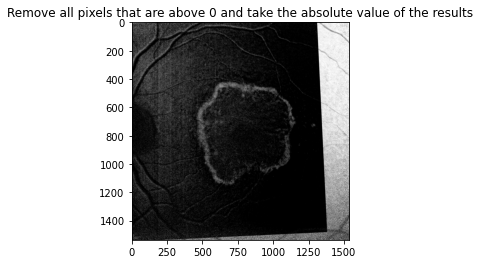

Threshold is -  0.283203125


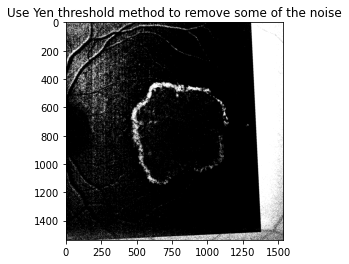

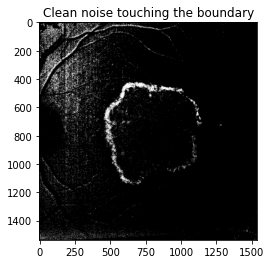

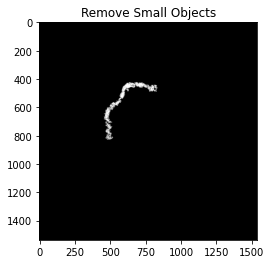

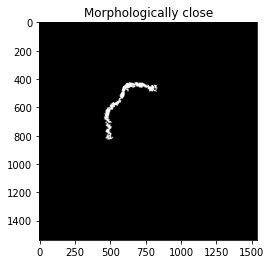

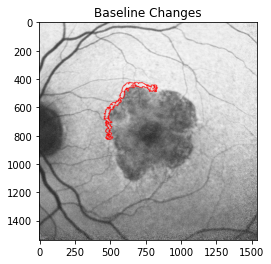

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


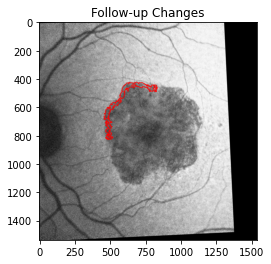

In [ ]:
bl1_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL01.tif'
fu1_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU01.tif'
detect_changes(bl1_path,fu1_path,0.56)

### BL3,FU3 - Yen thresholding

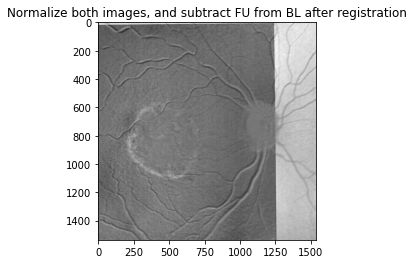

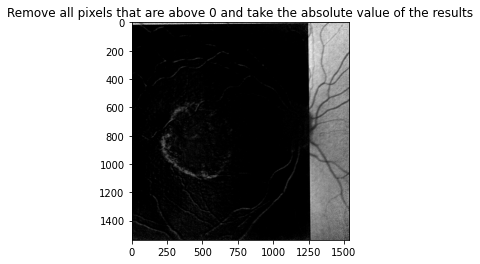

Threshold is -  0.099609375


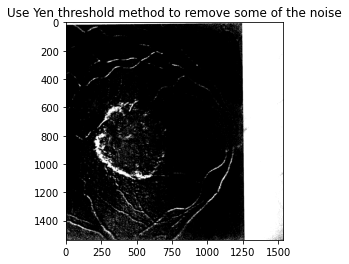

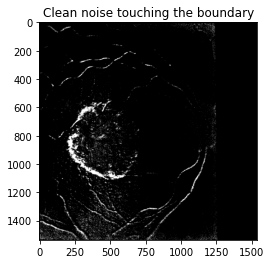

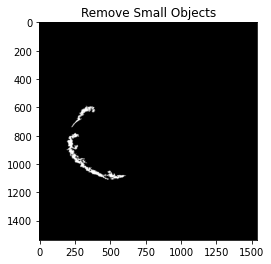

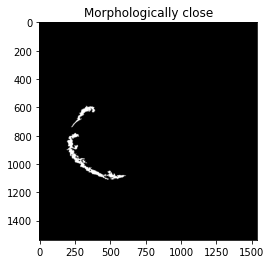

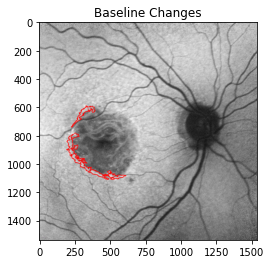

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


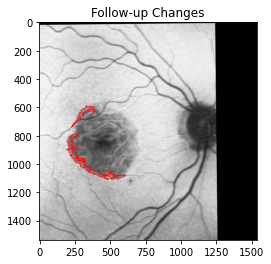

In [ ]:
detect_changes(bl3_path,fu3_path,0.3)

### BL5, FU5 - otsu thresholding

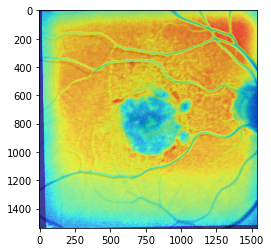

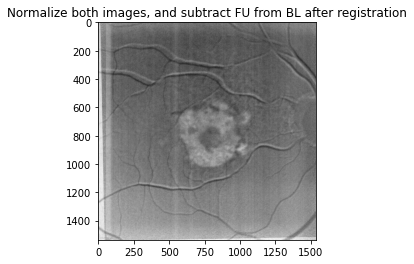

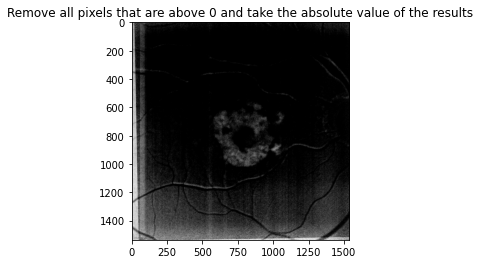

Threshold is -  0.232421875


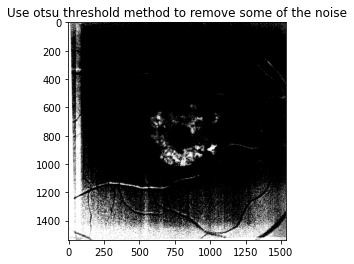

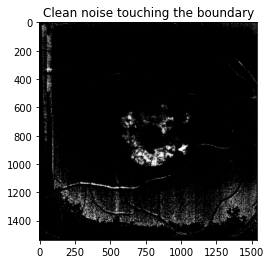

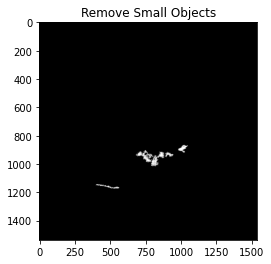

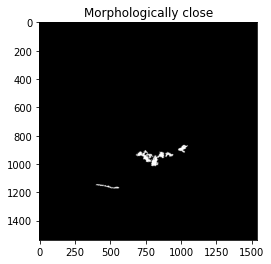

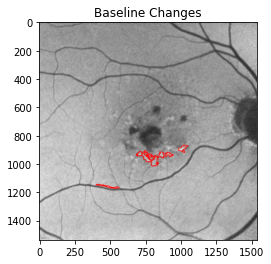

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


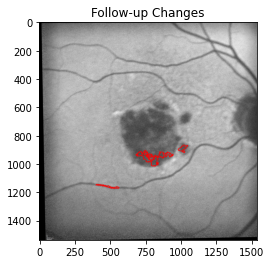

In [ ]:
detect_changes(bl5_path,fu5_path,0.45)

### BL3,FU3 - process

Explain in detail the output of each step in the algorithm I implemented.

Read images and remove caption

In [ ]:
bl_path = bl3_path
fu_path = fu3_path
ration = 0.3

In [ ]:
  bl = Image.open(bl_path)
  fu = Image.open(fu_path)
  bl_arr = np.array(bl)
  fu_arr = np.array(fu)
  bl = remove_caption_bottom(bl_arr)
  fu = remove_caption_bottom(fu_arr)
  BLPoints,FUPoints = getPoints(bl,fu,ration)

Registrate follow up image

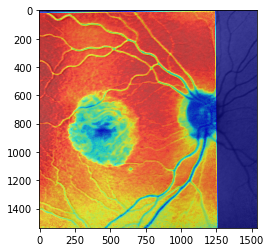

In [ ]:
  fu_registration = Registration(bl,fu,BLPoints,FUPoints)

Change rgb image to gray

In [ ]:
bl_gray = rgb2gray(bl)
fu_registration_gray = rgb2gray(fu_registration)

1. Normalize images
2. substract fu from bl
3. remove values above 0 and take the absolute value
4. threshold the image using Yen algorithm 

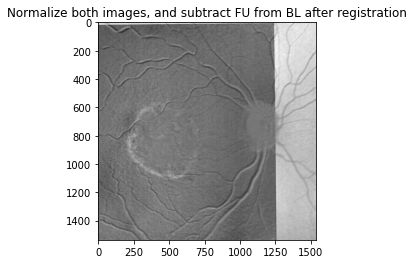

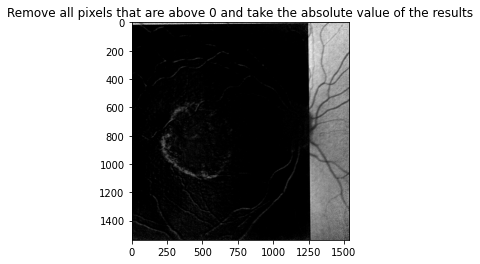

Threshold is -  0.099609375


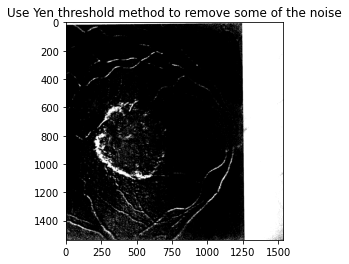

In [ ]:
normalized_bl = normalize(bl_gray, axis=0, norm="max")
normalized_fu = normalize(fu_registration_gray, axis=0, norm="max")
sub = normalized_bl - normalized_fu
plt.title("Normalize both images, and subtract FU from BL after registration")
plt.imshow(sub,cmap='gray')
plt.show()
remove_vals_above_zero = np.abs(np.where(sub<0,0,sub))
plt.title("Remove all pixels that are above 0 and take the absolute value of the results")
plt.imshow(remove_vals_above_zero,cmap='gray')
plt.show()
thresh = threshold_yen(remove_vals_above_zero)
print("Threshold is - ",thresh)
binary = remove_vals_above_zero > thresh 
plt.title("Use Yen threshold method to remove some of the noise")
plt.imshow(binary,cmap='gray')
plt.show()

5. Clear image border
6. Remove small object 
7. Morphologic closing 

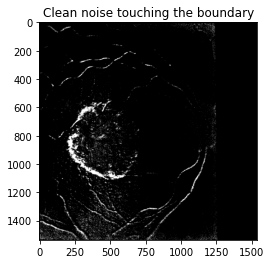

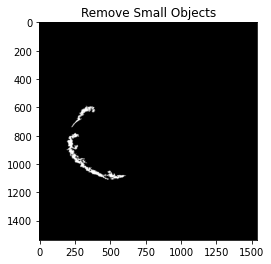

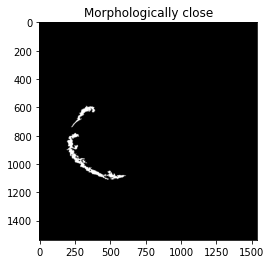

In [ ]:
clear_border_img = clear_border(binary)
plt.title("Clean noise touching the boundary")
plt.imshow(clear_border_img,cmap='gray')
plt.show()
remove_small_obj = remove_small_objects(clear_border_img,2000)
plt.title("Remove Small Objects")
plt.imshow(remove_small_obj,cmap='gray')
plt.show()
closing = binary_closing(remove_small_obj)
plt.title("Morphologically close")
plt.imshow(closing,cmap='gray')
plt.show()

In [ ]:
closing.shape

(1536, 1536)

Draw border - changes in baseline image relatively to follow-up image

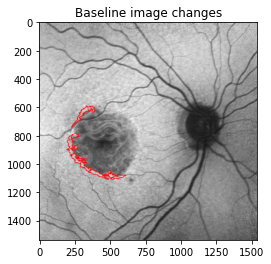

In [ ]:
    # BL_img = cv2.cvtColor(bl_gray.astype('uint8'), cv2.COLOR_GRAY2RGB)
    contours = cv2.findContours(closing.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(bl, contours[1], -1, (255, 0, 0), 3)
    plt.title("Baseline image changes")
    plt.imshow(bl, cmap='gray')
    plt.show()


Draw border - changes in follow-up image relatively to baseline image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


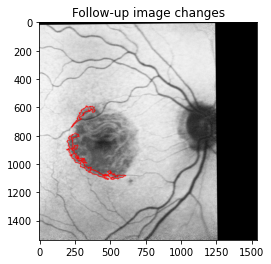

In [ ]:
    # FU_img = cv2.cvtColor(fu_final_cropped.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    contours = cv2.findContours(closing.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(fu_registration, contours[1], -1, (255, 0, 0), 3)
    plt.title("Follow-up image changes")
    plt.imshow(fu_registration, cmap='gray')
    plt.show()

## Example using Segmentation Registration 

### BL2, FU2 - flow of work

Registration

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10
Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7
Chosen angle is  0


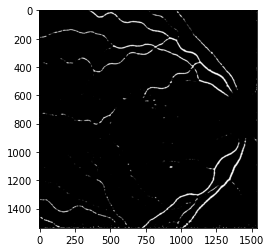

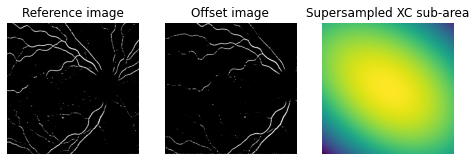

Detected subpixel offset (y, x): [  16.88 -289.7 ]


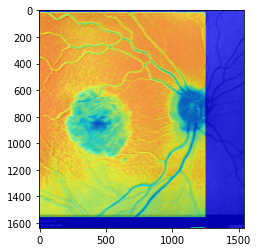

In [ ]:
fu_registration = Segmenatation_Registration(bl2,fu2)

Remove caption

In [ ]:
fu_final , translation , rotation_var = fu_registration
bl2_croped = remove_caption_bottom(bl2)
h,w = bl2_croped.shape
fu_final_cropped = fu_final[:h,:w]

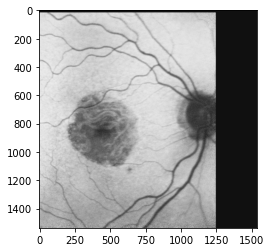

In [ ]:
plt.imshow(fu_final_cropped,cmap='gray')

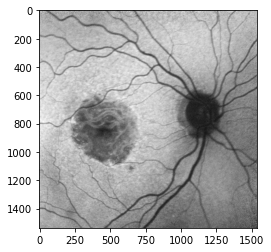

In [ ]:
plt.imshow(bl2_croped,cmap='gray')

Normalize both images, and subtract FU from BL after registration

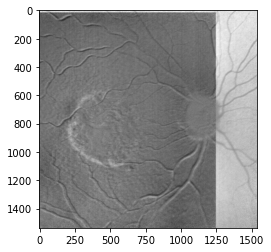

In [ ]:
normalized_bl = normalize(bl2_croped, axis=0, norm="max")
normalized_fu = normalize(fu_final_cropped, axis=0, norm="max")
sub = normalized_bl - normalized_fu
plt.imshow(sub,cmap='gray')

Remove all pixels that are above 0 and take the absolute value of the results

In [ ]:
remove_vals_above_zero = np.abs(np.where(sub<0,0,sub))

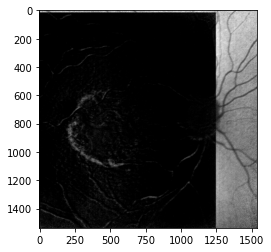

In [ ]:
plt.imshow(remove_vals_above_zero,cmap='gray')

Use some threshold method to remove some of the noise, without removing the lesion region.

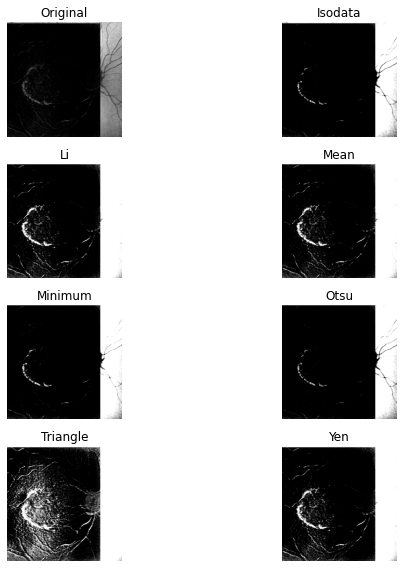

In [ ]:
fig, ax = try_all_threshold(remove_vals_above_zero, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
  #  thresh = threshold_minimum(remove_vals_above_zero)
  thresh = threshold_yen(remove_vals_above_zero)
  print("Threshold is - ",thresh)
  # fix threshold to better identify atrophy
  binary = remove_vals_above_zero > thresh 
  # binary = np.where(binary,0,1)

Threshold is -  0.103515625


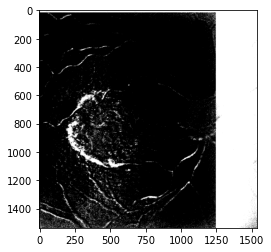

In [ ]:
plt.imshow(binary,cmap='gray')

Use skimage.segmentation.clear_border to clean noise touching the boundary.

In [ ]:
clear_border_img = clear_border(binary)

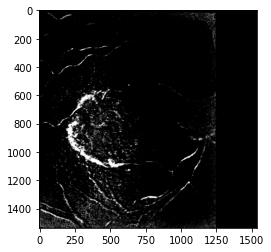

In [ ]:
plt.imshow(clear_border_img,cmap='gray')

Remove small objects.

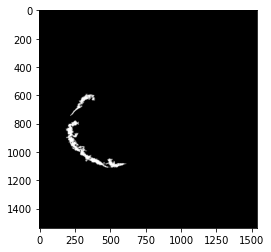

In [ ]:
remove_small_obj = remove_small_objects(clear_border_img,2000)
plt.imshow(remove_small_obj,cmap='gray')

Morphologically close

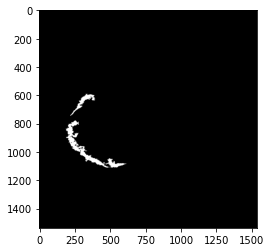

In [ ]:
closing = binary_closing(remove_small_obj)
plt.imshow(closing,cmap='gray')

Draw the borders

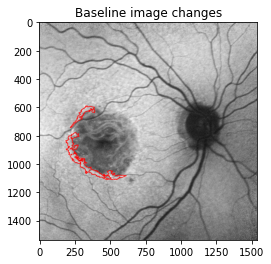

In [ ]:
    BL_img = cv2.cvtColor(bl2_croped.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    contours = cv2.findContours(closing.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(BL_img, contours[1], -1, (255, 0, 0), 3)
    plt.title("Baseline image changes")
    plt.imshow(BL_img, cmap='gray')
    plt.show()

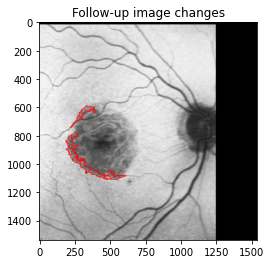

In [ ]:
    FU_img = cv2.cvtColor(fu_final_cropped.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    contours = cv2.findContours(closing.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(FU_img, contours[1], -1, (255, 0, 0), 3)
    plt.title("Follow-up image changes")
    plt.imshow(FU_img, cmap='gray')
    plt.show()

### BL3, FU3 - flow of work

Registration

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10
Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7
Chosen angle is  0


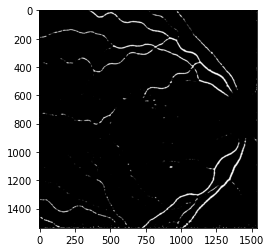

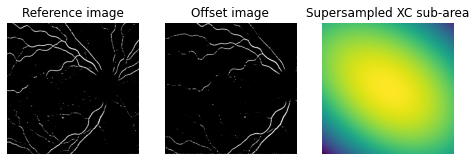

Detected subpixel offset (y, x): [  16.88 -289.7 ]


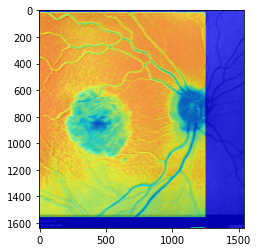

In [ ]:
fu3_registration = Segmenatation_Registration(bl3,fu3)

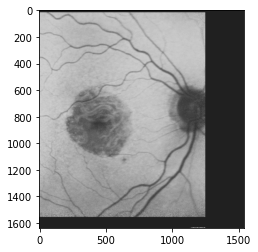

In [ ]:
fu3_final , translation , rotation_var = fu3_registration
plt.imshow(fu3_final,cmap = 'gray')

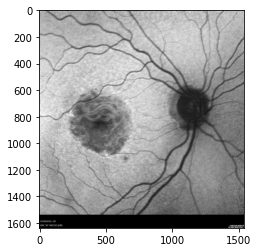

In [ ]:
plt.imshow(bl3,cmap = 'gray')

Normalize both images, and subtract FU from BL after registration

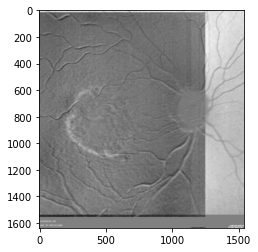

In [ ]:
normalized_bl3 = normalize(bl3, axis=0, norm="max")
normalized_fu3 = normalize(fu3_final, axis=0, norm="max")
sub = normalized_bl3 - normalized_fu3
plt.imshow(sub,cmap='gray')

Remove all pixels that are above 0 and take the absolute value of the results

In [ ]:
remove_vals_above_zero = np.abs(np.where(sub<0,0,sub))

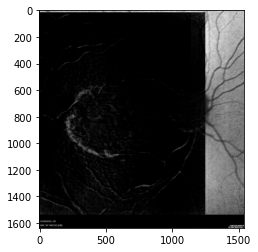

In [ ]:
plt.imshow(remove_vals_above_zero,cmap='gray')

Use some threshold method to remove some of the noise, without removing the lesion region.

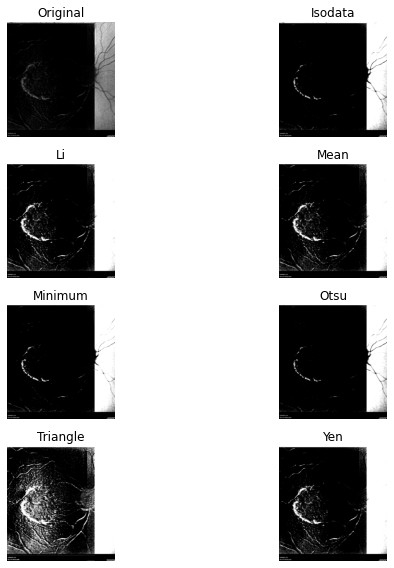

In [ ]:
fig, ax = try_all_threshold(remove_vals_above_zero, figsize=(10, 8), verbose=False)
plt.show()

Threshold is -  0.107421875


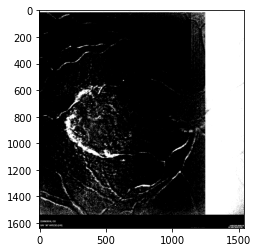

In [ ]:
  #  thresh = threshold_minimum(remove_vals_above_zero)
  thresh = threshold_yen(remove_vals_above_zero)
  print("Threshold is - ",thresh)
  # fix threshold to better identify atrophy
  binary = remove_vals_above_zero > thresh 
  plt.imshow(binary,cmap='gray')

Use skimage.segmentation.clear_border to clean noise touching the boundary.

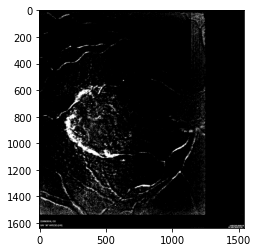

In [ ]:
from skimage.segmentation import clear_border
clear_border_img = clear_border(binary)
plt.imshow(clear_border_img,cmap='gray')

Remove small objects.

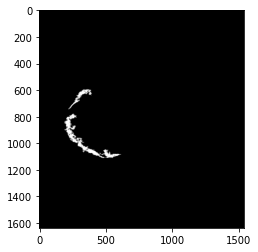

In [ ]:
remove_small_obj = remove_small_objects(clear_border_img,2000)
plt.imshow(remove_small_obj,cmap='gray')

Morphologically close

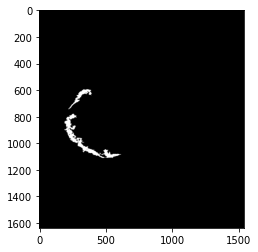

In [ ]:
closing = binary_closing(remove_small_obj)
plt.imshow(closing,cmap='gray')

Draw the borders

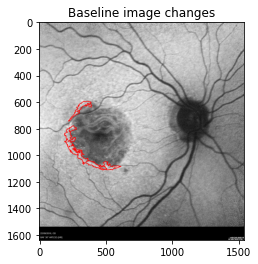

In [ ]:
    BL_img = cv2.cvtColor(bl3.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    contours = cv2.findContours(closing.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(BL_img, contours[1], -1, (255, 0, 0), 3)
    plt.title("Baseline image changes")
    plt.imshow(BL_img, cmap='gray')
    plt.show()

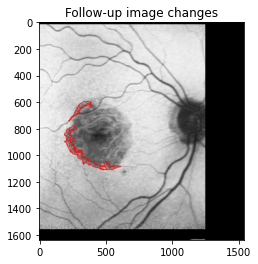

In [ ]:
    FU_img = cv2.cvtColor(fu3_final.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    contours = cv2.findContours(closing.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(FU_img, contours[1], -1, (255, 0, 0), 3)
    plt.title("Follow-up image changes")
    plt.imshow(FU_img, cmap='gray')
    plt.show()